# Unsupervised Learning

### Practical 2 (Solutions)

Before starting this practical, please work through both 

* the ASML: Induction notebook (if not done so yet) 
* the notebook UL: Lecture 2 relating to Part 2 of the lecture

In this practical, we will need both the programming devices and the data sets introduced there.

After completing/revising the Induction notebook, please continue from here.


We recall the data sets considered in those notebooks:

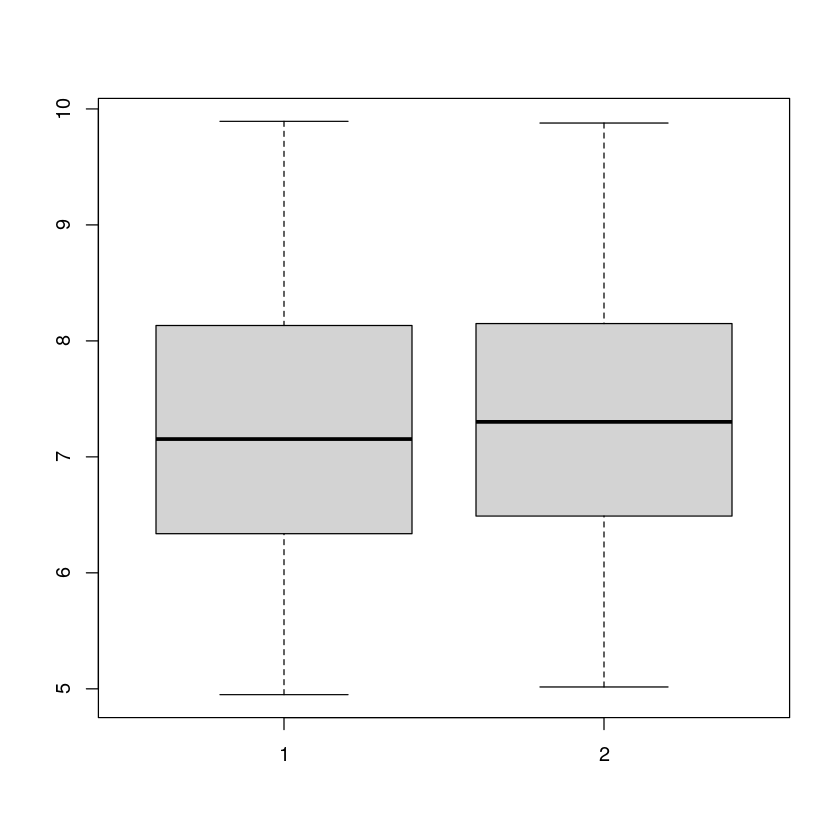

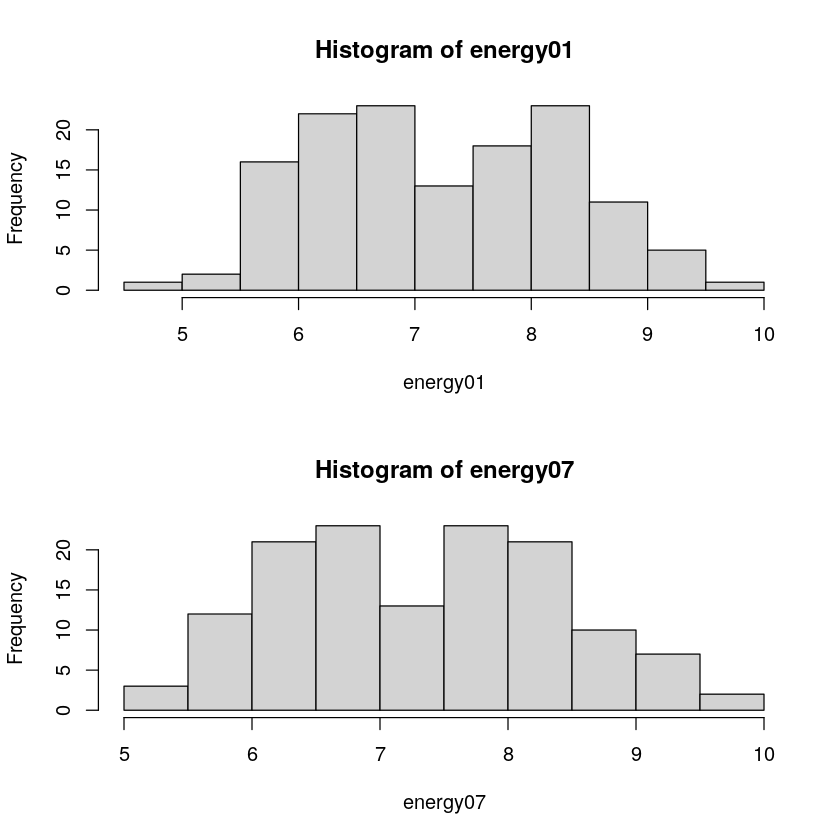

In [1]:
energy.use <- read.csv("http://www.maths.dur.ac.uk/~dma0je/Data/energy.csv", header=TRUE)
energy <- energy.use[,c("X2001", "X2007")]
rownames(energy)<- energy.use[, 1]
colnames(energy)<- c("use01", "use07")
energy01<- log(energy$use01)
energy07<- log(energy$use07)
boxplot(energy01, energy07)
par(mfrow=c(2,1))                     
hist(energy01) 
hist(energy07) 

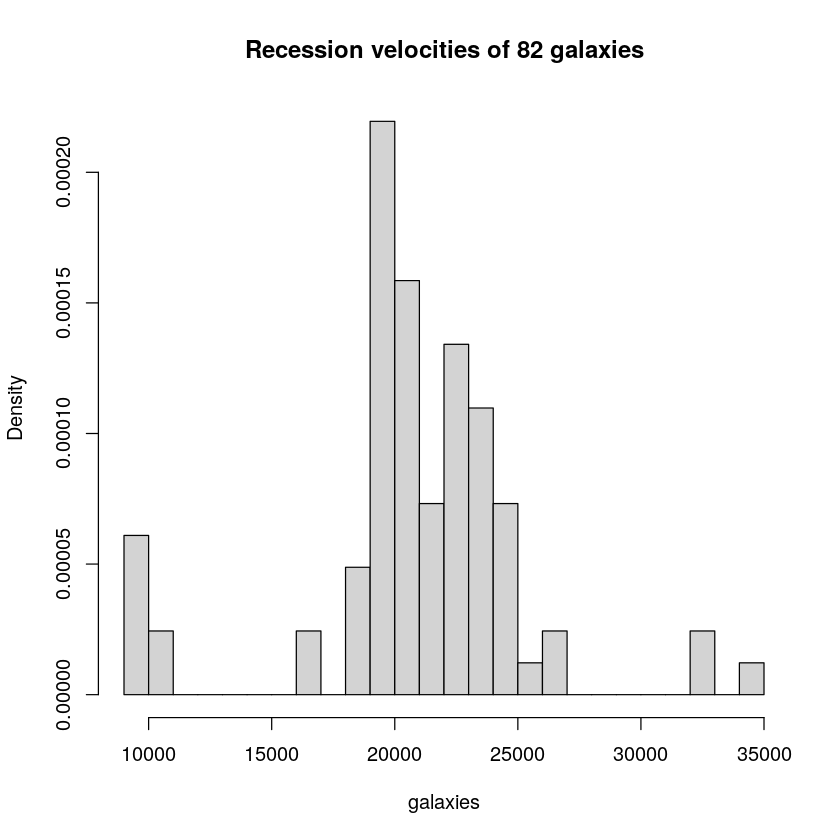

In [2]:
data(galaxies, package="MASS")
hist(galaxies, freq=FALSE, breaks=18, main="Recession velocities of 82 galaxies")

Recall also the EM algorithm, including plotting function, which we have already implemented:

In [3]:
estep <- function(dat, p, mu, sigma){         
   n <- length(dat)
   K <- length(mu) 
   W <- matrix(0, n,K)
   for (i in 1:n){
        W[i,]<- p/sigma*exp(-1/(2*sigma^2)*(dat[i]-mu)^2)/sum( p/sigma*exp(-1/(2*sigma^2)*(dat[i]-mu)^2))
      }
  return(W)
 }

mstep <- function(dat, W){                    
   n <- dim(W)[1]
   K <- dim(W)[2]
   
   p  <- apply(W,2,sum)/n
   mu <- apply(W*dat,2,sum)/apply(W,2,sum)
  
   diff <-matrix(0,n, K)
   for (k in 1:K){ diff[,k]<- (dat -mu[k])^2  }
   var   <- apply(W*diff,2,sum)/apply(W,2,sum)
   sigma <- sqrt(var)

  return(list("p"=p, "mu"=mu,  "sigma"=sigma))
} 

em <- function(dat,K, steps=400){                   
  p     <- rep(1/K,K)
  mu    <- quantile(dat, probs= (1:K)/K-1/(2*K))  
  sigma <- rep(sd(dat), K)
  
  s <- 1
  while (s <=steps){
    W   <- estep(dat, p, mu, sigma)
    fit <- mstep(dat, W)
    p   <- fit$p
    mu  <- fit$mu
    sigma <-fit$sigma
    s   <- s+1
 }
    fit<- list("p"=p, "mu"=mu, "sigma"=sigma,  "W" =W)
 return(fit)  
 }

plot.mix<- function(dat, p, mu, sigma, breaks=25, dens=TRUE, ngrid=401, ...){
  try<-  hist(dat, breaks=breaks,  plot=FALSE)
  hist(dat, breaks=breaks, freq=FALSE, ylim=c(0, max(try$density)*1.3), col="grey93" , border="grey85",...)
  r <- diff(range(dat))
  grid<- seq(min(dat)-0.15*r, max(dat)+0.15*r, length=ngrid)
  K<- length(p)
  if (length(sigma)==1){
    sigma<-rep(sigma, K)
  }
  grid.mat<- matrix(0, ngrid,K)
  for (j in 1:K){
    grid.mat[,j]<- p[j]*dnorm(grid, mu[j], sigma[j])
  }
  for (j in 1:K){
    lines(grid, grid.mat[,j], col=j+1, lwd=2)
  }
  if (dens){
    lines(grid, apply(grid.mat,1, sum), col=1,lwd=2)
  }   
  invisible()  
}

and which we have already applied on data sets `energy01` and `galaxies`.

Apply function `em` now on data set `energy07`. Report the fitted mixture parameters and visualize the fitted mixture.

[1] 6.385115 8.103641

[1] 0.5404329 0.7155785

[1] 0.4472613 0.5527387

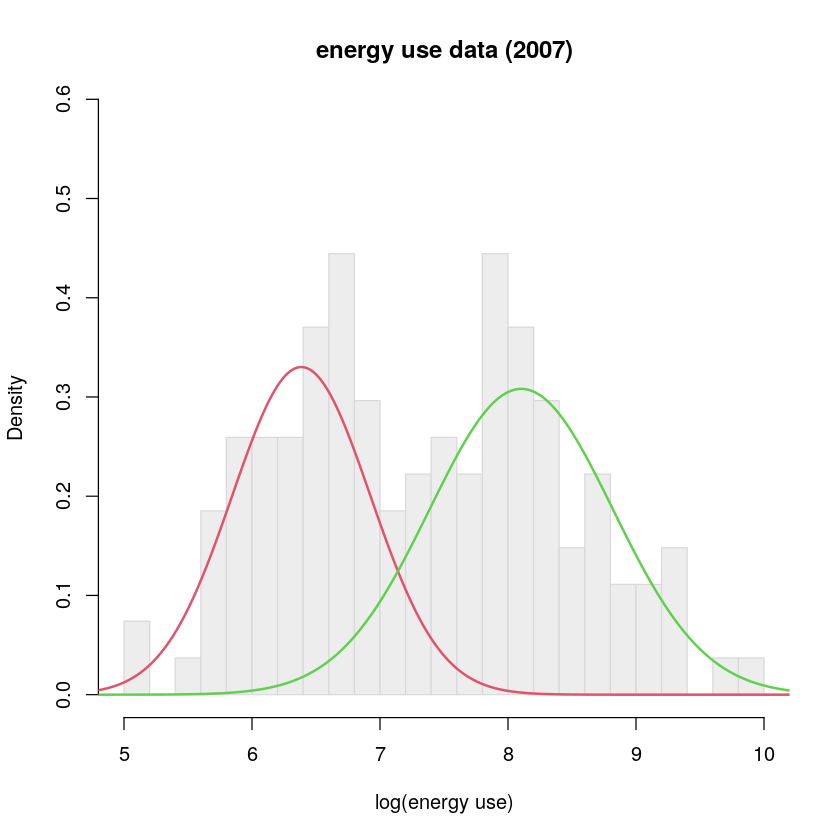

In [4]:
fit.em <- em(energy07, K=2) 
fit.em$mu
fit.em$sigma
fit.em$p
plot.mix(energy07, fit.em$p, fit.em$mu, fit.em$sigma, main="energy use data (2007)", xlab="log(energy use)",  dens=FALSE) 

We now wish to compare this result to a standard R package for fitting mixture models. Please load R package `mixtools`, and study the help file of function `normalmixEM`. Then apply `normalmixEM` on the `energy07` data, with two mixture components. Compare the results to the manual implementation. 

In [5]:
require(mixtools)
fit.mix2 <- normalmixEM(energy07, k=2)

fit.mix2$mu
fit.mix2$sigma
fit.mix2$lambda

# We see that the two results are almost perfectly identical (note this does not need necessarily be the case)

Loading required package: mixtools

mixtools package, version 1.2.0, Released 2020-02-05
This package is based upon work supported by the National Science Foundation under Grant No. SES-0518772.




number of iterations= 107 


[1] 6.385150 8.103691

[1] 0.5404492 0.7155506

[1] 0.4472852 0.5527148

The remainder of this practical will be devoted to the implementation of a bootstrap test, in order to test for the number of components.  This is the test displayed, without code, on slide 33 of Part 2 of the lecture material. Please read briefly through that slide before proceeding further.

We see that, in order to implement this test, for 


$H_0$: $K$ components versus $H_1$: $K+1$ components


we need, essentially, to be able to do two things:

* simulate data from a mixture model (under $H_0$);
* evaluate the quantity $D=-2 \log L$  under both the null and the alternative hypothesis, so that we can compute the likelihood ratio statistic.

$LR=  D_{K}-D_{K+1}$

where the subscripts $K$ and $K+1$ indicate the models with $K$ and $K+1$ components, respectively. The quantity $D$ is sometimes called *disparity* in the literature.




Now, simulating from a Gaussian mixture has been addressed on Slide 29 of Part 2. We reproduce the relevant code here:

In [6]:
gauss.mix.sim<-function(n, p, mu, sigma){          
   x  <- runif(n)
   sim <-rep(0,n)
   cp <-cumsum(p)
   for (i in 1:n){
       k <-1
       while (x[i]>cp[k]){
           k<-k+1
       }    
       sim[i] <- rnorm(1,mu[k],sigma[k])
   }
   return(sim)
 }

Concerning the evaluation of $D$, we can't do this (yet) based on our own function `em`, but fortunately `normalmixEM` provides a way out. To see this, please type `names(object)` where `object` is the name assigned to your mixture model fitted through `normalmixEM` above. You will see that this contains an element `$loglik`. Display the value of this.

In [7]:
names(fit.mix2)
fit.mix2$loglik

[1] "x"          "lambda"     "mu"         "sigma"      "loglik"    
[6] "posterior"  "all.loglik" "restarts"   "ft"

[1] -194.4988

This is $\log(L)$, so $D$ is easily computed from this. Do this for this fitted model.

In [8]:
D<- -2* fit.mix2$loglik
D

[1] 388.9976

Having now all components available, implement the bootstrap routine from Slide 29, for the `energy07` data, for testing $K=2$ versus $K=3$ components; i.e. 

(1) initially fit the model for $K=2$ and $K=3$ components, and compute the likelihood ratio statistic

(2) then, do the following $B$ times (say, $B=99$):

* Simulate a new data set (of the same sample size as the original one) from  the model fitted for $K=2$ in (1)
* Fit the model for $K=2$ and $K=3$ for this data set, and compute the resulting likelihood ratio statistic

(3) Find the position of the LR value from (1) within the B LR values from (2). This value, devided by 100, will be the p-value of the test. (Hint: You can use the `rank` function to do this.)

We apply a $5\%$ level of significance; i.e. we will reject $H_0$ if the p-value falls below this value.

Please set the random seed `set.seed(20)` to ensure some reproducibility. 

Some code fragments for (1), (2) and (3) are already given in the below windows.


Step (1):

In [9]:
  set.seed(20) 

  fit.mix2 <- normalmixEM(energy07, k=2)
  fit.mix3 <- normalmixEM(energy07, k=3)
  LRTS <- -2*fit.mix2$loglik + 2*fit.mix3$loglik

  print(fit.mix2$loglik)
  print(fit.mix3$loglik)

number of iterations= 122 
number of iterations= 723 
[1] -194.4988
[1] -193.1773


Step (2): 

In [10]:
  M <- 99
  sim.LRTS <-rep(0,M)
  n <- length(energy07)

  for (m in 1:M){
     sim2 <- gauss.mix.sim(n, p=fit.mix2$lambda, mu=fit.mix2$mu, sigma=fit.mix2$sigma)
     fit.sim2<-  normalmixEM(sim2,k=2, verb=FALSE)
     fit.sim3<-  normalmixEM(sim2,k=3, verb=FALSE)
     sim.LRTS[m]<- -2*fit.sim2$loglik + 2*fit.sim3$loglik
  }




number of iterations= 104 
WARNING! NOT CONVERGENT! 
number of iterations= 1000 
number of iterations= 76 
WARNING! NOT CONVERGENT! 
number of iterations= 1000 
number of iterations= 196 
number of iterations= 717 
number of iterations= 314 
number of iterations= 490 
number of iterations= 267 
number of iterations= 563 
number of iterations= 108 
number of iterations= 364 
number of iterations= 162 
number of iterations= 655 
number of iterations= 118 
number of iterations= 149 
number of iterations= 119 
number of iterations= 270 
number of iterations= 151 
number of iterations= 353 
number of iterations= 41 
number of iterations= 197 
number of iterations= 84 
number of iterations= 432 
number of iterations= 200 
WARNING! NOT CONVERGENT! 
number of iterations= 1000 
number of iterations= 154 
number of iterations= 221 
number of iterations= 101 
number of iterations= 410 
number of iterations= 69 
number of iterations= 409 
number of iterations= 48 
number of iterations= 211 
number

Step (3): 

In [11]:
pval <- 1-rank(c(LRTS, sim.LRTS))[1]/100  
pval 

[1] 0.64

Apply the `hist` function with options `right=FALSE` and `breaks=50` on `sim.LRTS` in order to visualize the simulated null distribution. Highlight the observed value of `LRTS`, for instance through a vertical line. 

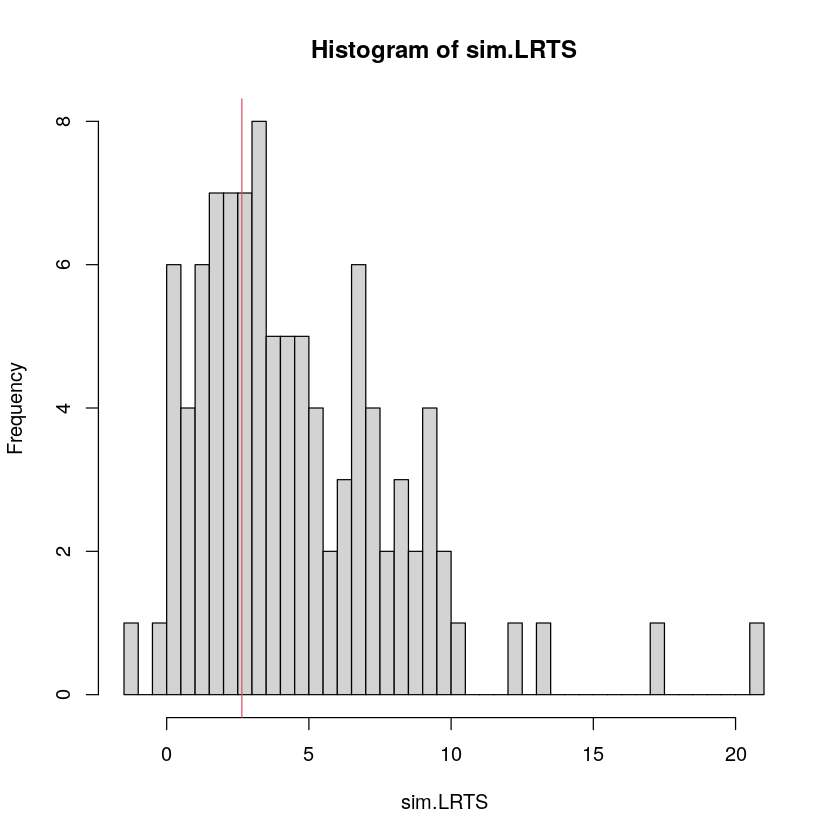

In [12]:
hist(sim.LRTS, right=FALSE, breaks=50)
abline(v=LRTS, col=2)

If the model for $K=2$ is rejected, keep going with this procedure until it stops rejecting. 

In [13]:
# not the case!

Display the parameter estimates of the final model, and visusalize the fitted model graphically.

$lambda
[1] 0.5527625 0.4472375

$mu
[1] 8.103591 6.385080

$sigma
[1] 0.7156062 0.5404167

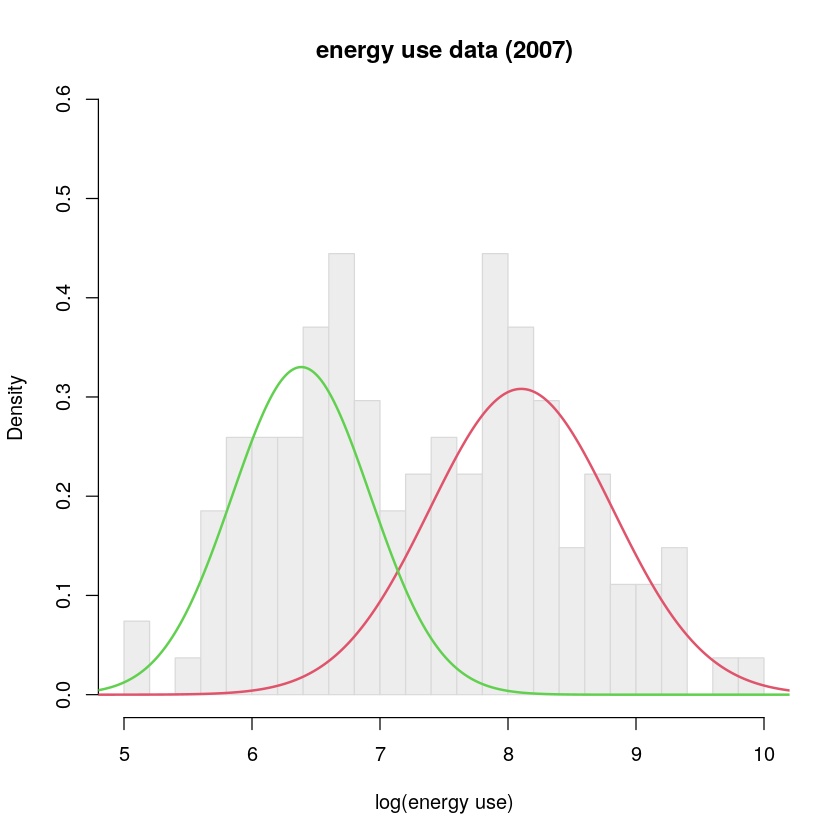

In [14]:
fit.mix2[c("lambda","mu", "sigma")]
plot.mix(energy07, fit.mix2$lambda, fit.mix2$mu, fit.mix2$sigma, main="energy use data (2007)", xlab="log(energy use)",  dens=FALSE) 

# (same as above)

**Advanced and optional**:

Now, we may want to be able to do the same with our own EM implementation. Therefore, we need to extend the capabilities of our function `em` so that it can produce the likelihood of the fitted model. Note that the task is *not* to find the complete (log)- likelihood, but the actual model (log-) likelihood, i.e. the expression at the bottom of page 11, evaluated at the parameter estimates.

The easiest way of achieving this is to create, after the completion of the loop in the `em` function, a $n \times K$ matrix, say $P$, of the expressions $p_k f_{ik}$. Note that `p[k]*dnorm(dat, mu[k],sigma[k])` provides immediately the $k$th column of $P$. Then, the remaining task is to sum adequately over the rows and columns of $P$. (Hint: Use `apply`). Equip your function with adequate outputs for $\log L$ and/or $D$. 

Produce the EM algorithm with this extension. Call the resulting function `EM`.


In [15]:
EM <- function(dat,K, steps=400){ 
  p     <- rep(1/K,K)
  mu    <- quantile(dat, probs= (1:K)/K-1/(2*K))  
  sigma <- rep(sd(dat), K)
  
  s<-1
  while (s <=steps){
    W   <- estep(dat, p, mu, sigma)
    fit <- mstep(dat, W)
    mu  <- fit$mu
    p  <- fit$p
    sigma<- fit$sigma
    s<-s+1
  }
  P<-matrix(0,length(dat), K)
  for (k in 1:K){
    P[,k]<- p[k]*dnorm(dat, mu[k],sigma[k])
  }
  loglik<- sum(log(apply(P,1,sum)))
  
  fit<- list("p"=p, "mu"=mu, "sigma"=sigma, "wik" =W,"data"=dat, "disp"=-2*loglik )
  class(fit)<-"EM"
  return(fit)  
}

Apply this new function to the galaxy data, for $K=4$. Display the value of $D$ for the fitted model.

In [16]:
galaxy.fit4<- EM(galaxies, K=4 )
galaxy.fit4$disp

[1] 1537.194

Now use the bootstrap routine developed earlier to test the hypothesis $H_0: K=4$ versus $H_1: K=5$ for the galaxy data.

In [17]:
  data(galaxies, package="MASS")
  n <- length(galaxies)

  fit4 <- EM(galaxies, K=4)
  fit5 <- EM(galaxies, K=5)
  LRTS <- fit4$disp-fit5$disp

  M <- 99
  sim.LRTS <-rep(0,M)
  for (m in 1:M){
     sim4 <- gauss.mix.sim(n, p=fit4$p, mu=fit4$mu, sigma=fit4$sigma)
     fit.sim4<-  EM(sim4,4, steps=100)
     fit.sim5<-  EM(sim4,5, steps=100)
     sim.LRTS[m]<- fit.sim4$disp-fit.sim5$disp
  }

pval <- 1-rank(c(LRTS, sim.LRTS))[1]/100  
pval   

[1] 0.23

Note: The higher the values of $K$ that are involved, the less likely it is that the results of `EM` and `normalmixEM` will agree. One reason is that the starting point selection mechanism in `EM` is quite simple; the approach taken in `normalmixEM` is more elaborate which results in a better chance of actually maximizing the likelihood.